In [1]:
from patchify import patchify
from transformers import SamModel, SamProcessor, SamConfig
import torch
from datasets import Dataset
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import random
import time
import cv2 as cv

from utils import *

c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.

In [2]:
paths = {
    'train': {'images':   r"data/sam_finetuning/train/images/",
              'masks':    r"data/sam_finetuning/train/masks/",
              'bboxes':   r"data/sam_finetuning/train/bboxes/"},
    'val':   {'images':   r"data/sam_finetuning/val/images/",
              'masks':    r"data/sam_finetuning/val/masks/",
              'bboxes':   r"data/sam_finetuning/val/bboxes/"},
    'test':  {'images':   r"data/sam_finetuning/test/images/",
              'masks':    r"data/sam_finetuning/test/masks/",
              'bboxes':   r"data/sam_finetuning/test/bboxes/"}
}

train_images = get_images(paths['train']['images'])
val_images   = get_images(paths['val']['images'])
test_images  = get_images(paths['test']['images'])

train_masks  = get_images(paths['train']['masks'])
val_masks    = get_images(paths['val']['masks'])
test_masks   = get_images(paths['test']['masks'])

train_bboxes = get_bboxes(paths['train']['bboxes'])
val_bboxes   = get_bboxes(paths['val']['bboxes'])
test_bboxes  = get_bboxes(paths['test']['bboxes'])

n_train = len(train_images)
n_val   = len(val_images)
n_test  = len(test_images)

print(f'num train_images: {n_train}')
print(f'num val_images: {n_val}')
print(f'num test_images: {n_test}')

original_dims = (512, 641)

num train_images: 411
num val_images: 102
num test_images: 101


In [3]:
nosat_images = get_images(r'data/nosat/')
nosat_masks = np.zeros((len(nosat_images), original_dims[0], original_dims[1], 3))
nosat_bboxes = [None] * len(nosat_images)

# max_test_key = max(test_images.keys())
# for key in nosat_images:
#     test_images[max_test_key + key] = nosat_images[key]
#     test_masks[max_test_key + key] = np.zeros(original_dims)
#     test_bboxes[max_test_key + key] = None
    
print(f'num nosat_images: {len(nosat_images)}')

num nosat_images: 101


In [4]:
train_dict = {
    'image': [Image.fromarray(img.astype('uint8')) for img in train_images.values()],
    'mask': [Image.fromarray(mask.astype('uint8')) for mask in train_masks.values()],
    'bbox': [(x, y, w, h) for (x, y), w, h in train_bboxes.values()],
}
val_dict = {
    'image': [Image.fromarray(img.astype('uint8')) for img in val_images.values()],
    'mask': [Image.fromarray(mask.astype('uint8')) for mask in val_masks.values()],
    'bbox': [(x, y, w, h) for (x, y), w, h in val_bboxes.values()],
}
test_dict = {
    'image': [Image.fromarray(img.astype('uint8')) for img in test_images.values()],
    'mask': [Image.fromarray(mask.astype('uint8')) for mask in test_masks.values()],
    'bbox': [(x, y, w, h) for (x, y), w, h in test_bboxes.values()],
}
nosat_dict = {
    'image': [Image.fromarray(img.astype('uint8')) for img in nosat_images.values()],
    'mask': [Image.fromarray(mask.astype('uint8')) for mask in nosat_masks],
    'bbox': nosat_bboxes,
}
combo_dict = {
    'image': test_dict['image'] + nosat_dict['image'],
    'mask': test_dict['mask'] + nosat_dict['mask'],
    'bbox': test_dict['bbox'] + nosat_dict['bbox'],
}

train_dataset = Dataset.from_dict(train_dict)
val_dataset   = Dataset.from_dict(val_dict)
test_dataset  = Dataset.from_dict(test_dict)
nosat_dataset = Dataset.from_dict(nosat_dict)
combo_dataset = Dataset.from_dict(combo_dict)

In [ ]:
def resize_image(img_arr: np.ndarray, w: int, h: int) -> np.ndarray:
    img = Image.fromarray(img_arr)
    img = img.resize((w, h))
    return np.array(img)

In [ ]:
# Get bounding boxes from mask. (FROM ONLINE SOURCE)
def get_bounding_box(ground_truth_map: np.ndarray) -> list[int]:
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [ ]:
patch_size = 256
# image_size = 512

avg_train_area: 481.8905109489051
avg_val_area: 1120.6176470588234


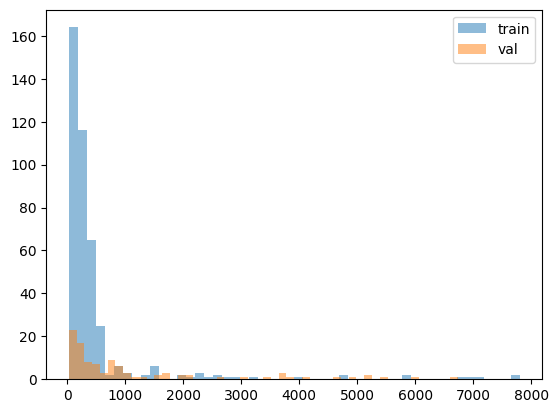

avg_train_area: 260.0703125
avg_val_area: 405.0


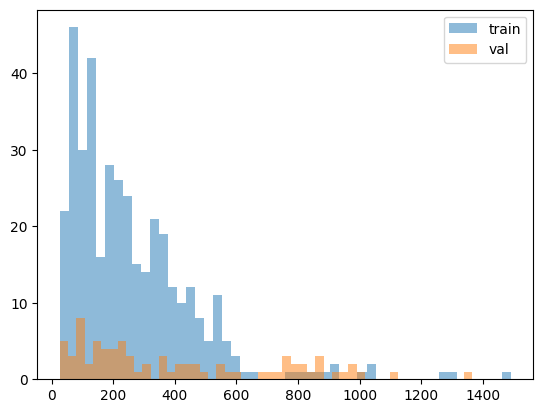

In [ ]:
# Find average area of all training and validation masks
train_areas = []
val_areas = []
for key in train_masks:
    train_areas.append(np.sum(train_masks[key] > 0))
for key in val_masks:
    val_areas.append(np.sum(val_masks[key] > 0))

avg_train_area = np.mean(train_areas)
avg_val_area = np.mean(val_areas)
print("avg_train_area:", avg_train_area)
print("avg_val_area:", avg_val_area)

# plot train areas and val areas
plt.hist(train_areas, bins=50, alpha=0.5, label='train')
plt.hist(val_areas, bins=50, alpha=0.5, label='val')
plt.legend(loc='upper right')
plt.show()

# remove outliers from both areas lists
train_areas = [area for area in train_areas if area < 1500]
val_areas = [area for area in val_areas if area < 1500]

avg_train_area = np.mean(train_areas)
avg_val_area = np.mean(val_areas)
print("avg_train_area:", avg_train_area)
print("avg_val_area:", avg_val_area)
plt.hist(train_areas, bins=50, alpha=0.5, label='train')
plt.hist(val_areas, bins=50, alpha=0.5, label='val')
plt.legend(loc='upper right')
plt.show()


In [ ]:
def load_model_and_processor(model_path) -> tuple[SamModel, SamProcessor]:
    # Load the model configuration
    model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    print(model_path)
    # Create an instance of the model architecture with the loaded configuration
    model = SamModel(config=model_config)
    # Update the model by loading the weights from saved file.
    model.load_state_dict(torch.load(model_path))
    
    return model, processor

def load_model_and_processor2(model_path) -> tuple[SamModel, SamProcessor]:
    # Load the model configuration
    model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    print(model_path)
    # Create an instance of the model architecture with the loaded configuration
    model = SamModel(config=model_config)
    # Update the model by loading the weights from saved file.
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, processor

def get_device() -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device

In [ ]:
def has_satellite(image, vit_classifier, vit_feature_extractor):
    image_tensor = vit_feature_extractor(images=image, return_tensors="pt")["pixel_values"].to(get_device())
    logits = vit_classifier(image_tensor).logits
    prediction = logits.argmax(axis=-1)
    return bool(prediction == 1)

def prepare_image(image: np.ndarray, dims: tuple[int, int], verbose=True) -> torch.Tensor:
    start_time = time.time()
    
    image = resize_image(image, dims[0], dims[1])
    patches = patchify(np.array(image), (patch_size, patch_size, 3), step=256)
    patches = np.squeeze(patches)
    
    end_time = time.time()
    
    if verbose:
        print(f"Time taken to prepare image: {end_time - start_time:.2f} seconds")
    
    return patches

def calculate_distance_with_all_neighbors(contours_info):
    coords = []
    for contour_info in contours_info:
        bbox = contour_info['bounding_box']
        x, y, w, h = bbox['x'], bbox['y'], bbox['width'], bbox['height']
        # find midpoint of rect
        x_mid = x + w // 2
        y_mid = y + h // 2
        coords.append((x_mid, y_mid))

    tot_dist = 0
    num_dists = 0
    for i in range(len(coords)):
        for j in range(i+1, len(coords)):
            x1, y1 = coords[i]
            x2, y2 = coords[j]
            dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            tot_dist += dist
            num_dists += 1
    
    power = 1
    if num_dists == 0: return 1
    # print("tot_dist, num_dists, tot_dist / (num_dists**power)", tot_dist, num_dists, tot_dist / (num_dists ** power))
    return tot_dist**2


# def predict(model: SamModel, processor: SamProcessor, device: torch.device, image: torch.Tensor, dims: tuple[int, int], thresh: float = 0.5, verbose=True) -> (torch.Tensor, torch.Tensor):
#     start_time = time.time()
#     model.eval()
    
#     patches = prepare_image(image, dims, verbose=verbose)
    
#     prob_patches = []
    
#     for row_patches in patches:
#         prob_patches.append([])
#         for patch in row_patches:
#             inputs = processor(patch, return_tensors="pt")
#             inputs = {k:v.to(device) for k,v in inputs.items()}
            
#             with torch.no_grad():
#                 outputs = model(**inputs, multimask_output=False)
#             single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
#             single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
#             single_patch_prob = single_patch_prob / np.sum(single_patch_prob)
            
#             # Gaussian blur
#             single_patch_prob = cv.GaussianBlur(single_patch_prob, (7, 7), 0)
            
#             prob_patches[-1].append(single_patch_prob)
    
#     prob_patches = np.array(prob_patches)
#     prob_patches_max = np.max(prob_patches)
#     # prob_patches = prob_patches / prob_patches_max
    
#     patch_contour_dists = []
#     patch_contour_counts = []
#     patch_contour_bboxes = []
#     patch_contour_areas = []
    
#     fig, axs = plt.subplots(patches.shape[0], patches.shape[1], figsize=(10, 10))
    
#     for i in range(prob_patches.shape[0]):
#         patch_contour_dists.append([])
#         patch_contour_counts.append([])
#         patch_contour_bboxes.append([])
#         patch_contour_areas.append([])
        
#         for j in range(prob_patches.shape[1]):
#             patch = prob_patches[i][j]
#             # print("patch.max()", patch.max())
#             tot_dist_factor = patch.max()
#             # patch = np.where(patch > patch.max()*thresh, patch, 0)
#             patch = patch / patch.max() * 255
#             patch = patch * (tot_dist_factor / prob_patches_max)
            
#             patch = patch.astype(np.uint8)
#             patch = np.stack((patch, patch, patch), axis=2)
#             imgray = cv.cvtColor(patch, cv.COLOR_BGR2GRAY)
#             ret, t = cv.threshold(imgray, 127, 255, 0)
#             contours, hierarchy = cv.findContours(t, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
#             contours_info = []
#             for contour in contours:
#                 area = cv2.contourArea(contour)
#                 perimeter = cv2.arcLength(contour, True)
#                 x, y, w, h = cv2.boundingRect(contour)
#                 contours_info.append({
#                     'area': area,
#                     'perimeter': perimeter,
#                     'bounding_box': {'x': x, 'y': y, 'width': w, 'height': h}
#                 })
                
#                 if perimeter == 0: continue
                
#                 circularity = 4 * np.pi * area / (perimeter**2)
#                 # tot_dist_factor = tot_dist_factor * 
#                 print("circularity", circularity)
#             print()
            
#             tot_dist = calculate_distance_with_all_neighbors(contours_info)

#             tot_dist = tot_dist / (tot_dist_factor**2)
#             # tot_dist = tot_dist * sum([i['area'] for i in contours_info])
#             # print("tot_dist factor, tot_dist", tot_dist_factor, tot_dist)
            
#             patch_contour_dists[-1].append(tot_dist)
#             patch_contour_counts[-1].append(len(contours))
#             patch_contour_bboxes[-1].append([i['bounding_box'] for i in contours_info])
#             patch_contour_areas[-1].append(sum([i['area'] for i in contours_info]))
            
#             cv.drawContours(patch, contours, -1, (0, 255, 0), 3)
#             axs[i, j].imshow(cv.cvtColor(patch, cv.COLOR_BGR2RGB))
#             axs[i, j].axis('off')  # Hide axes
    
#     patch_contour_counts = np.array(patch_contour_counts)
#     patch_contour_areas = np.array(patch_contour_areas)
#     patch_contour_dists = np.array(patch_contour_dists)
#     dists_sum = sum([1/d for d in patch_contour_dists.flatten()])

#     prob = None
#     for i in range(prob_patches.shape[0]):
#         row_prob = None
#         for j in range(prob_patches.shape[1]):
#             single_patch_prob = prob_patches[i][j]
            
#             contour_mask = np.zeros(single_patch_prob.shape)
#             for bbox in patch_contour_bboxes[i][j]:
#                 x, y, w, h = bbox['x'], bbox['y'], bbox['width'], bbox['height']
#                 contour_mask[y:y+h, x:x+w] = True
#             single_patch_prob = np.where(contour_mask, single_patch_prob, 0)
            
#             contour_factor = 1
#             contour_factor = 1/(patch_contour_dists[i][j] * dists_sum)
#             if patch_contour_counts[i][j] == 0 or patch_contour_areas[i][j] <= 0.1:
#                 contour_factor /= 10
#             else:
#                 # contour_factor /= patch_contour_areas[i][j]
#                 contour_factor /= patch_contour_counts[i][j]
#                 # print("counter count", patch_contour_counts[i][j])
#                 print("contour_area", patch_contour_areas[i][j])
                
            
#             # contour_factor = 1
#             print("contour_factor", contour_factor)
#             single_patch_prob = single_patch_prob * (contour_factor)
#             filtering_factor = np.sum(single_patch_prob > single_patch_prob.max() * thresh) / np.sum(single_patch_prob > 0)
#             filtering_factor = 1
#             # print(np.sum(single_patch_prob > single_patch_prob.max() * thresh), np.sum(single_patch_prob > 0))
#             # print("filtering_factor", filtering_factor)
#             single_patch_prob = single_patch_prob * (filtering_factor)
            
#             if row_prob is None:
#                 row_prob = single_patch_prob
#             else:
#                 row_prob = np.concatenate((row_prob, single_patch_prob), axis=1)
#         if prob is None:
#             prob = row_prob
#         else:
#             prob = np.concatenate((prob, row_prob), axis=0)
    
    
#     pred = (prob > prob.max() * thresh).astype(np.uint8)
    
#     pred = resize_image(pred, original_dims[1], original_dims[0])
#     prob = resize_image(prob, original_dims[1], original_dims[0])
    
#     end_time = time.time()
#     if verbose:
#         print(f"Time taken to predict: {end_time - start_time:.2f} seconds")
    
#     return pred, prob


def predict(model: SamModel, processor: SamProcessor, device: torch.device, image: torch.Tensor, dims: tuple[int, int], thresh: float = 0.5, verbose=True, vit_classifier=None, vit_feature_extractor=None) -> (torch.Tensor, torch.Tensor):
    if not (vit_classifier and vit_feature_extractor): return None, None
    print(image.shape[:-1])
    start_time = time.time()
    model.eval()
    
    patches = prepare_image(image, dims, verbose=verbose)
    prob_patches = []
    
    has_sats = []
    
    for row_patches in patches:
        prob_patches.append([])
        has_sats.append([])
        for patch in row_patches:
            has_sat = has_satellite(patch, vit_classifier, vit_feature_extractor)
            if verbose: print("has_sat", has_sat)
            has_sats[-1].append(has_sat)

            inputs = processor(patch, return_tensors="pt")
            inputs = {k:v.to(device) for k,v in inputs.items()}
            
            with torch.no_grad():
                outputs = model(**inputs, multimask_output=False)
            single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
            single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
            single_patch_prob = single_patch_prob / np.sum(single_patch_prob)
            
            # Gaussian blur
            single_patch_prob = cv.GaussianBlur(single_patch_prob, (7, 7), 0)
            
            prob_patches[-1].append(single_patch_prob)
    
    if sum([has_sat for row in has_sats for has_sat in row]) == 0:
        return np.zeros((original_dims[0], original_dims[1])), np.zeros((original_dims[0], original_dims[1]))
    
    prob_patches = np.array(prob_patches)
    prob_patches_max = np.max(prob_patches)
    # prob_patches = prob_patches / prob_patches_max
    
    patch_contour_dists = []
    patch_contour_counts = []
    patch_contour_bboxes = []
    patch_contour_areas = []
    
    if verbose: 
        fig, axs = plt.subplots(patches.shape[0], patches.shape[1], figsize=(10, 10))
    
    for i in range(prob_patches.shape[0]):
        patch_contour_dists.append([])
        patch_contour_counts.append([])
        patch_contour_bboxes.append([])
        patch_contour_areas.append([])
        
        for j in range(prob_patches.shape[1]):
            patch = prob_patches[i][j]
            tot_dist_factor = patch.max()
            patch = patch / patch.max() * 255
            # patch = patch * (tot_dist_factor / prob_patches_max)
            
            patch = patch.astype(np.uint8)
            patch = np.stack((patch, patch, patch), axis=2)
            imgray = cv.cvtColor(patch, cv.COLOR_BGR2GRAY)
            ret, t = cv.threshold(imgray, 127, 255, 0)
            contours, hierarchy = cv.findContours(t, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
            contours_info = []
            for contour in contours:
                area = cv2.contourArea(contour)
                perimeter = cv2.arcLength(contour, True)
                x, y, w, h = cv2.boundingRect(contour)
                contours_info.append({
                    'area': area,
                    'perimeter': perimeter,
                    'bounding_box': {'x': x, 'y': y, 'width': w, 'height': h}
                })
                
            tot_dist = calculate_distance_with_all_neighbors(contours_info)

            tot_dist = tot_dist / (tot_dist_factor**2)
            
            patch_contour_dists[-1].append(tot_dist)
            patch_contour_counts[-1].append(len(contours))
            patch_contour_bboxes[-1].append([i['bounding_box'] for i in contours_info])
            patch_contour_areas[-1].append(sum([i['area'] for i in contours_info]))
            
            if verbose: 
                cv.drawContours(patch, contours, -1, (0, 255, 0), 3)
                axs[i, j].imshow(cv.cvtColor(patch, cv.COLOR_BGR2RGB))
                axs[i, j].axis('off')  # Hide axes
    
    patch_contour_counts = np.array(patch_contour_counts)
    patch_contour_areas = np.array(patch_contour_areas)
    patch_contour_dists = np.array(patch_contour_dists)
    dists_sum = sum([1/d for d in patch_contour_dists.flatten()])

    prob = None
    for i in range(prob_patches.shape[0]):
        row_prob = None
        for j in range(prob_patches.shape[1]):
            single_patch_prob = prob_patches[i][j]
            
            contour_mask = np.zeros(single_patch_prob.shape)
            for bbox in patch_contour_bboxes[i][j]:
                x, y, w, h = bbox['x'], bbox['y'], bbox['width'], bbox['height']
                
                # top = max(0, y - int(0.5*h))
                # bottom = min(original_dims[0], y + int(1.5*h))
                # left = max(0, x - int(0.5*w))
                # right = min(original_dims[1], x + int(1.5*w))
                # contour_mask[top:bottom, left:right] = True
                
                contour_mask[y:y+h, x:x+w] = True
            
            single_patch_prob = np.where(contour_mask, single_patch_prob, 0)
            
            contour_factor = 1
            contour_factor = 1/(patch_contour_dists[i][j] * dists_sum)
            if patch_contour_counts[i][j] == 0 or patch_contour_areas[i][j] <= 1:
                pass
            else:
                contour_factor /= patch_contour_counts[i][j]
            if vit_classifier and vit_feature_extractor:
                if not has_sats[i][j]:
                    contour_factor = 0
            
            # contour_factor = 1
            # print("contour_factor", contour_factor)
            single_patch_prob = single_patch_prob * (contour_factor)
            
            if row_prob is None:
                row_prob = single_patch_prob
            else:
                row_prob = np.concatenate((row_prob, single_patch_prob), axis=1)
        if prob is None:
            prob = row_prob
        else:
            prob = np.concatenate((prob, row_prob), axis=0)
    
    
    pred = (prob > prob.max() * thresh).astype(np.uint8)
    
    pred = resize_image(pred, original_dims[1], original_dims[0])
    prob = resize_image(prob, original_dims[1], original_dims[0])
    
    end_time = time.time()
    if verbose:
        print(f"Time taken to predict: {end_time - start_time:.2f} seconds")
    
    return pred, prob


def plot_prediction(image: np.ndarray, prediction: np.ndarray, probability: np.ndarray, idx: int, bbox: tuple = None) -> None:
    if bbox:
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    else:
        fix, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first image on the left
    axes[0].imshow(np.array(image), cmap='gray')  # Assuming the first image is grayscale
    axes[0].set_title(idx)

    # Plot the second image on the right
    axes[1].imshow(probability)  # Assuming the second image is grayscale
    axes[1].set_title("Probability Map")

    # Plot the second image on the right
    axes[2].imshow(prediction, cmap='gray')  # Assuming the second image is grayscale
    axes[2].set_title("Prediction")
    
    if bbox:
        axes[3].imshow(prediction, cmap='gray') 
        axes[3].set_title("Prediction with bbox")
        
        x, y, w, h = bbox
        r = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        axes[3].add_patch(r)

    # Hide axis ticks and labels
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Display the images side by side
    plt.show()

In [919]:
device = get_device()

models = {}
processors = {}

model_paths = {
    # 512: "finetuned_sam_checkpoints/512_checkpoints_2/epoch_15.pt",
    512:  "finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_10.pt",
    # 5120: "finetuned_sam_checkpoints/512.pth",
    1024: "finetuned_sam_checkpoints/1024.pth",
    2048: "finetuned_sam_checkpoints/2048.pth"
}

for size in model_paths.keys():
    model, processor = load_model_and_processor2(model_paths[size]) if size == 512 else load_model_and_processor(model_paths[size])
    model.to(device)
    models[size] = model
    processors[size] = processor
    
torch.cuda.empty_cache()

finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_10.pt
finetuned_sam_checkpoints/1024.pth
finetuned_sam_checkpoints/2048.pth


In [894]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

# vit_classifier = ViTForImageClassification.from_pretrained('results/final/checkpoint').to(device)
vit_classifier = ViTForImageClassification.from_pretrained('results/train_and_val/checkpoint-660').to(device)
vit_feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


(512, 641)
Time taken to prepare image: 0.00 seconds
has_sat True
has_sat False
has_sat False
has_sat False
Time taken to predict: 0.87 seconds
(512, 641) [184, 126, 17, 17]
0.9024390243902439
True


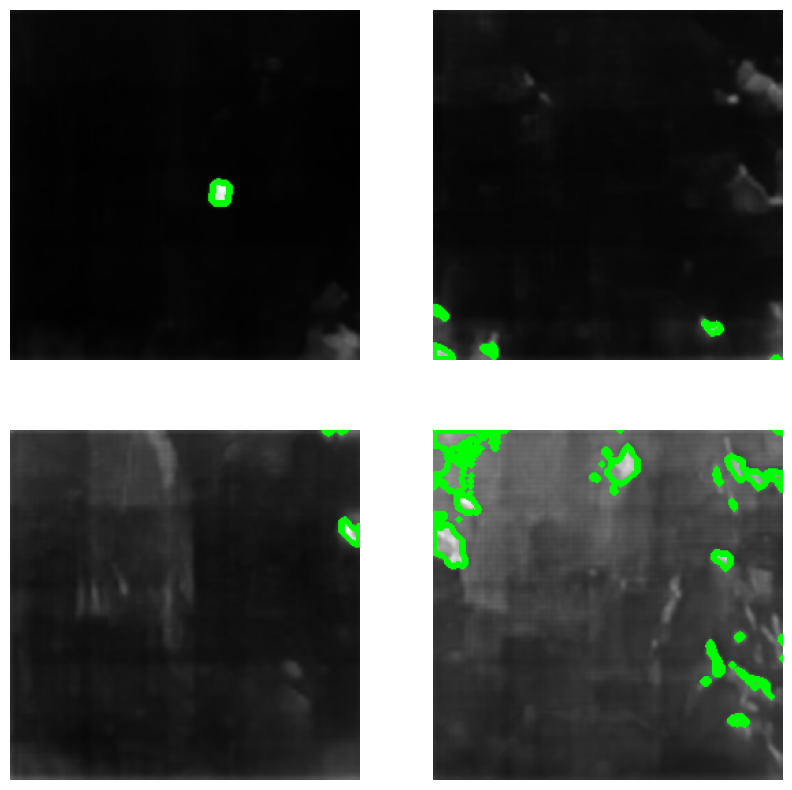

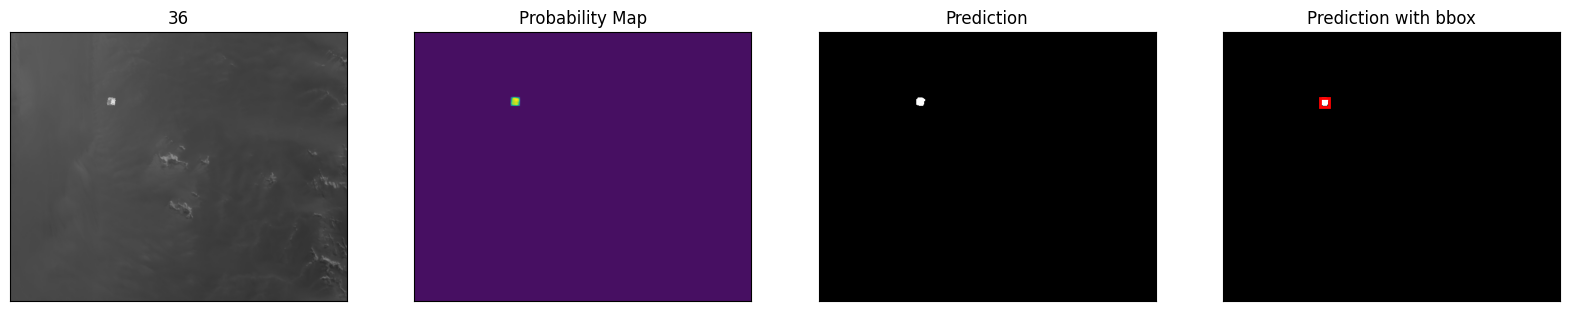

In [918]:
image_size = 512
model = models[image_size]
processor = processors[image_size]

def sample_prediction(image_size, model, processor, dataset):
    device = get_device()
    model.to(device)

    idx = random.randint(0, len(dataset)-1)
    # idx = 2
    # idx = 79
    
    item = dataset[idx]
    image = np.array(item['image'])
    bbox = item['bbox']
    mask = np.array(item['mask'])

    mask_pred, mask_prob = predict(model, processor, device, image, (image_size, image_size), 0.6, verbose=True, vit_classifier=vit_classifier, vit_feature_extractor=vit_feature_extractor)

    def mask_within_bbox2(mask, bbox: tuple[tuple[int, int], int, int], thresh: float = 0.5) -> bool:
        mask_img = np.array(mask, dtype=np.uint8)
        tot_area = np.sum(mask_img)
        
        x, y, w, h = bbox
        
        area_in_bbox = 0
        for dw in range(w):
            for dh in range(h):
                if mask_img[y + dh, x + dw] == 1:
                    area_in_bbox += 1

        return area_in_bbox / tot_area >= thresh, area_in_bbox / tot_area

    def joint_intersection(mask1, mask2, thresh) -> bool:
        intersection = np.logical_and(mask1, mask2)
        union = np.logical_or(mask1, mask2)
        if union.sum() == 0:
            return True, 0
        return np.sum(intersection) / np.sum(union) >= thresh, np.sum(intersection) / np.sum(union)

    within, ratio = mask_within_bbox2(mask_pred, bbox)
    within, ratio = joint_intersection(mask_pred, mask[:, :, 0], 0.5)
    print(ratio)
    if within:
        print(True)
    else:
        print(False)

    plot_prediction(image, mask_pred, mask_prob, idx, bbox)
    
# sample_prediction(512, model, processor, test_dataset)
sample_prediction(512, model, processor, combo_dataset)

In [818]:
# from torch.utils.data import DataLoader

# test_sam_dataset = SAMDataset(dataset=test_dataset, processor=processor)
# test_dataloader = DataLoader(test_sam_dataset, batch_size=2, shuffle=True, drop_last=False)

In [ ]:
# from torch.optim import Adam
# import monai
# from statistics import mean

# model = models[512]
# optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
# seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# model.eval()
# losses = []
# for batch in tqdm(test_dataloader):
#     # forward pass
#     outputs = model(pixel_values=batch["pixel_values"].to(device),
#                     input_boxes=batch["input_boxes"].to(device),
#                     multimask_output=False)

#     # compute loss
#     predicted_masks = outputs.pred_masks.squeeze(1)
#     ground_truth_masks = batch["ground_truth_mask"].float().to(device)
#     loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

#     loss.backward()
#     losses.append(loss.item())

In [ ]:
# print(f'Mean DiceCELoss: {mean(losses)}')

In [833]:
def mask_within_bbox(mask: np.ndarray, bbox: tuple[tuple[int, int], int, int]) -> bool:
    tot_area = np.sum(mask)
    
    (x, y), w, h = bbox
    
    area_in_bbox = 0
    for dw in range(w):
        for dh in range(h):
            if mask[y + dh, x + dw] == 1:
                area_in_bbox += 1

    return area_in_bbox / tot_area > 0.5

def joint_intersection(mask1, mask2, thresh) -> bool:
        intersection = np.logical_and(mask1, mask2)
        union = np.logical_or(mask1, mask2)
        if union.sum() == 0:
            return True, 0
        return np.sum(intersection) / np.sum(union) >= thresh, np.sum(intersection) / np.sum(union)

In [835]:
def calc_accuracy(model: SamModel, processor: SamProcessor, dataset, image_size: int, thresh: float = 0.5):
    device = get_device()
    model.to(device)

    x_factor = original_dims[1] / image_size
    y_factor = original_dims[0] / image_size
    
    accuracies = []
    ratios = []
    for idx in tqdm(range(len(dataset))):
        item = dataset[idx]
        image = np.array(item['image'])
        bbox = item['bbox']
        mask_true = np.array(item['mask'])[:, :, 0]
        
        mask_pred, _ = predict(model, processor, device, image, (image_size, image_size), thresh, verbose=False, vit_classifier=vit_classifier, vit_feature_extractor=vit_feature_extractor)
        # bbox = bboxes[idx]
        
        if bbox is None:
            if mask_pred.max() == 0:
                accuracies.append(1)
            else:
                accuracies.append(0)
            continue
        
        # (x, y), w, h = bbox
        # bbox = ((round(x/x_factor), round(y/y_factor)), round(w/x_factor), round(h/y_factor))
        
        # mask_true = np.array(masks[idx][:, :, 0] / 255, dtype=np.uint8)
        # within, ratio = mask_within_bbox2(mask_pred, bbox)
        within, ratio = joint_intersection(mask_pred, mask_true, 0.5)
        ratios.append(ratio)
        if within:
            accuracies.append(1)
        else:
            accuracies.append(0)
 
    return np.mean(accuracies), ratios

In [910]:
test_acc_512, test_ratios_512 = calc_accuracy(models[512], processors[512], combo_dataset, 512, thresh=0.65)
print(test_acc_512)

##### NO SAT IMAGES INCLUDED

# 0.5 base        : 0.3492

#### 1:1 balance, thresh=0.5, joint intersection if not within_bbox, w contours if not no contours, epoch 10
# no contours : 0.4365
# dist**1     : 0.4920
# dist**3     : 0.4285
# within_bbox : 0.5952 
# tot_dist    : 0.5079
# tot_dist epoch 15 : 0.4761
# tot_dist**2, patch > patch.max()*thresh : 0.5238
# tot_dist**2, patch > patch.max()*thresh, within_bbox : 0.6111
# tot_dist**2, patch * (tot_dist_factor / prob_patches_max) : 0.5476
# tot_dist**2, patch * (tot_dist_factor / prob_patches_max), within_bbox : 0.5793
# same as above but only analyze patches with contours, contour_factor /= num_contours : 0.5794
# same as above but thresh=0.4 and only analyze patches with contours, contour_factor /= num_contours : 0.5159
# mask on contours : 0.5952
# mask on contours, within_bbox : 0.5952

#### 1:1 balance, thresh=0.4
# w contours  : 0.5000

#### 1:1 balance, thresh=0.3
# w contours  : 0.4285

#### 3:1 balance (thresh=0.5)
# no contours : 0.1746


##### NO SAT IMAGES NOT INCLUDED

### 1:1 balance, thresh=0.5, contour_factor /= num_contours if not specified, mask on contours for all
# mask on contours : 0.7326
# above but thresh=0.4 : 0.7029
# contour_factor /= area instead of contour_factor /= num_contours : 0.6633
# mask on contours larger size, no contour_factor /= num_contours : 0.7227
# mask on contours larger size : 0.4851
# mask on contours larger size, zero area <= 1 : 0.7326
# mask on contours normal size, zero area <= 1 : 0.7425
# above but thresh=0.65 or thresh=0.6 : 0.7623


##### 1:1 balance, with vit classifier, only has sat images
# base don't skip no has_sat: 0.8514
# skip no has_sat : 0.8514

####### final checkpoint
#### FULL sat and 17 no-sat    :  0.8220
#### FULL sat and FULL no-sat thresh=0.6 :  0.7277
#### FULL sat and FULL no-sat thresh=0.5 :  0.7079
#### FULL sat and FULL no-sat thresh=0.65 :  0.7376, mIoU: 0.7928
#### FULL sat and FULL no-sat thresh=0.65 old contour_factor no num_contour :  0.7326, mIoU: 0.8004
#### FULL sat and FULL no-sat thresh=0.6 old contour_factor : 0.7277
#### FULL sat and FULL no-sat thresh=0.65 old contour_factor : 0.7326, mIoU: 0.8004


####### train-and_val 660 checkpoint, thresh=0.65 old contour_factor
#### FULL sat and FULL no-sat : 0.7871, mIoU: 0.8000
#### FULL sat and NO no-sat : 0.8712, mIoU: 0.8000
#### NO sat and FULL no-sat : 0.7029, mIoU: nan
#### FULL sat and FULL no-sat, epoch 15 : 0.7772, mIoU: 0.7910

####### train-and_val 990 checkpoint
#### FULL sat and FULL no-sat thresh=0.65 old contour_factor : 0.7722, mIoU: 0.8000

100%|██████████| 202/202 [01:59<00:00,  1.69it/s]

0.7772277227722773


In [911]:
mIoU = np.mean([ratio for ratio in test_ratios_512 if ratio > 0.5])
print("mIoU:", mIoU)

mIoU: 0.7910306495218379


In [94]:
test_acc_1024 = calc_accuracy(models[1024], processors[1024], test_images, test_bboxes, test_masks, 1024, thresh=0.4)

# 0.4 w contours base : 0.1825
print(test_acc_1024)

100%|██████████| 126/126 [06:19<00:00,  3.01s/it]

0.18253968253968253


In [ ]:
# test_acc_2048 = calc_accuracy(models[2048], processors[2048], test_images, test_bboxes, 2048, thresh=0.65)
# print(test_acc_2048)

In [ ]:
def test_threshs(threshs: list[float], model: SamModel, processor: SamProcessor, images: dict[int, np.ndarray], bboxes: dict[int, tuple], masks, image_size: int) -> dict[float, float]:
    accs = {}
    for thresh in threshs:
        print(f"Testing threshold: {thresh}")
        acc = calc_accuracy(model, processor, images, bboxes, masks, image_size, thresh)
        print(f"Accuracy: {acc:.4f}\n")
        accs[thresh] = acc
    return accs

In [ ]:
thresh_accs_512 = test_threshs([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], models[512], processors[512], val_images, val_bboxes, val_masks, 512)

# 0.1 : 0.0196
# 0.2 : 0.1667
# 0.3 : 0.3039
# 0.4 : 0.4902
# 0.5 : 0.5294
# 0.6 : 0.5196
# 0.7 : 0.3431

Testing threshold: 0.1


100%|██████████| 102/102 [01:40<00:00,  1.02it/s]


Accuracy: 0.0196

Testing threshold: 0.2


100%|██████████| 102/102 [01:39<00:00,  1.02it/s]


Accuracy: 0.1667

Testing threshold: 0.3


100%|██████████| 102/102 [01:39<00:00,  1.02it/s]


Accuracy: 0.3039

Testing threshold: 0.4


100%|██████████| 102/102 [01:39<00:00,  1.02it/s]


Accuracy: 0.4902

Testing threshold: 0.5


100%|██████████| 102/102 [01:40<00:00,  1.02it/s]


Accuracy: 0.5294

Testing threshold: 0.6


100%|██████████| 102/102 [01:40<00:00,  1.02it/s]


Accuracy: 0.5196

Testing threshold: 0.7


100%|██████████| 102/102 [01:39<00:00,  1.02it/s]

Accuracy: 0.3431



In [ ]:
import pickle
pickle.dump(thresh_accs_512, open("thresh_accs_512.pkl", "wb"))

In [ ]:
# thresh_accs_1024 = test_threshs([0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7], models[1024], processors[1024], val_images, val_bboxes, 1024)

# import pickle
# pickle.dump(thresh_accs_1024, open("thresh_accs_1024_2.pkl", "wb"))

In [ ]:
# thresh_accs_2048 = test_threshs([0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7], models[2048], processors[2048], val_images, val_bboxes, 2048)

# import pickle
# pickle.dump(thresh_accs_2048, open("thresh_accs_2048_2.pkl", "wb"))

In [6]:
from src.segment_sat import SegmentSat

segment_sat = SegmentSat(sam_model_path='finetuned_sam_checkpoints/512_checkpoints_balanced/epoch_10.pt', 
                         vit_classifier_path='results/train_and_val/checkpoint-660')

c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Time taken to prepare image: 0.00 seconds
has_sat True
has_sat True
has_sat False
has_sat False
contour_factor 0.7523344764173444
contour_factor 0.24766549999241577
contour_factor 0
contour_factor 0
Time taken to predict: 0.77 seconds
IoU: 0.0
Incorrectly segmented.


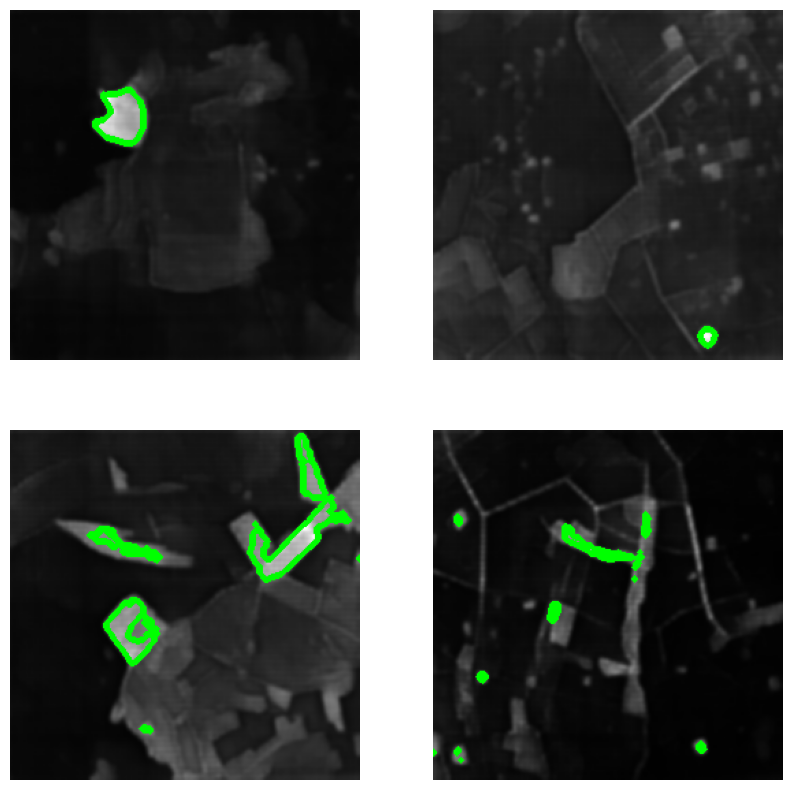

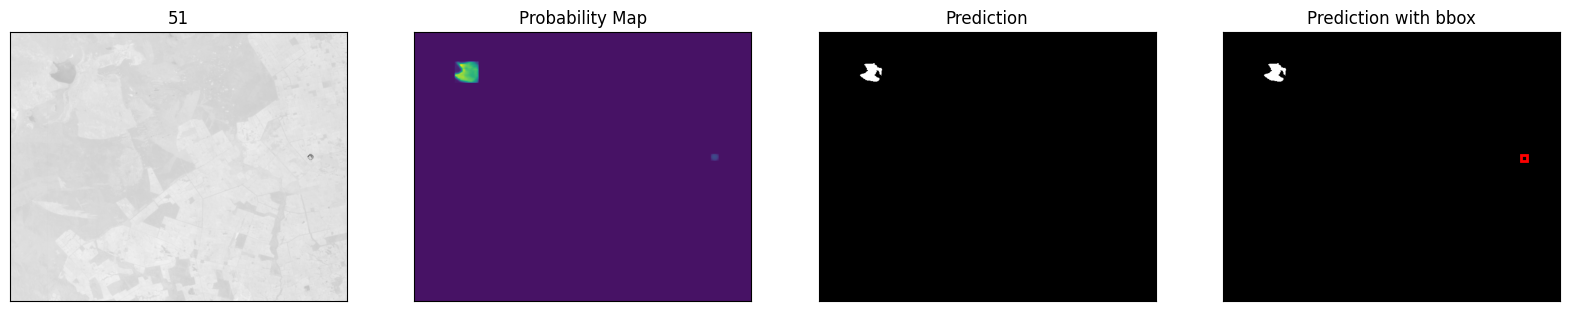

In [43]:
# segment_sat.sample_prediction(val_dataset, verbose=True, idx=14)
segment_sat.sample_prediction(val_dataset, verbose=True, idx=51)

In [16]:
acc = segment_sat.calc_accuracy(combo_dataset, thresh=0.65)
print(acc)

100%|██████████| 202/202 [02:01<00:00,  1.66it/s]

(0.7871287128712872, 0.7296364033095469)


In [12]:
train_acc, train_mIoU, _ = segment_sat.calc_accuracy(train_dataset, thresh=0.65)
print(train_acc, train_mIoU)

100%|██████████| 411/411 [04:03<00:00,  1.69it/s]

0.8077858880778589 0.7942554084690436


In [13]:
val_acc, val_mIoU, _ = segment_sat.calc_accuracy(val_dataset, thresh=0.65)
print(val_acc, val_mIoU)

100%|██████████| 102/102 [01:03<00:00,  1.60it/s]

0.8137254901960784 0.8215478010066972


In [18]:
val_acc2, val_mIoU2, _ = segment_sat.calc_accuracy(val_dataset, thresh=0.5)
print(val_acc2, val_mIoU2)

100%|██████████| 102/102 [01:03<00:00,  1.61it/s]

0.7745098039215687 0.8108383998750684


In [14]:
test_acc, test_mIoU, _ = segment_sat.calc_accuracy(test_dataset, thresh=0.65)
print(test_acc, test_mIoU)

100%|██████████| 101/101 [01:00<00:00,  1.67it/s]

0.8712871287128713 0.8000722274493153


In [19]:
test_acc2, test_mIoU2, _ = segment_sat.calc_accuracy(test_dataset, thresh=0.5)
print(test_acc2, test_mIoU2)

100%|██████████| 101/101 [01:02<00:00,  1.63it/s]

0.8217821782178217 0.8286266540970776


In [15]:
nosat_acc, nosat_mIoU, _ = segment_sat.calc_accuracy(nosat_dataset, thresh=0.65)
print(nosat_acc, nosat_mIoU)

100%|██████████| 101/101 [00:58<00:00,  1.71it/s]

0.7029702970297029 nan



c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [16]:
combo_acc, combo_mIoU, _ = segment_sat.calc_accuracy(combo_dataset, thresh=0.65)
print(combo_acc, combo_mIoU)

100%|██████████| 202/202 [01:58<00:00,  1.71it/s]

0.7871287128712872 0.8000722274493153


In [17]:
import pandas as pd
data = {
    'Dataset': ['Train', 'Val', 'Test', 'NoSat', 'Combo'],
    'Accuracy': [train_acc, val_acc, test_acc, nosat_acc, combo_acc],
    'mIoU': [train_mIoU, val_mIoU, test_mIoU, nosat_mIoU, combo_mIoU]
}
df = pd.DataFrame(data)
print(df)

  Dataset  Accuracy      mIoU
0   Train  0.807786  0.794255
1     Val  0.813725  0.821548
2    Test  0.871287  0.800072
3   NoSat  0.702970       NaN
4   Combo  0.787129  0.800072


In [ ]:
checkpoints_dir = '../finetuned_sam_checkpoints/512_checkpoints_balanced_better/'
pattern = os.path.join(checkpoints_dir, '*.pt')
file_list = glob.glob(pattern)

max_epochs = 15

epochs = np.arange(1, max_epochs + 1)
training_losses = np.zeros(max_epochs)

for file_path in file_list:
    file_path = file_path.replace('\\', '/')
    epoch_num = int(file_path.split('_')[-1][:-3])
    
    if epoch_num != max_epochs:
        continue
    
    checkpoint = torch.load(file_path)
    tr_loss = checkpoint['tr_metrics']
    
    for e, d in tr_loss.items():
        training_losses[e - 1] = d['loss']


plt.plot(epochs, training_losses)